In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/unicef/

In [ ]:
! pip install -r requirements.txt

In [2]:
import polars as pl

In [3]:
# Load all CSVs as string columns first to avoid parse errors
unicef_indicator_1 = pl.read_csv("unicef_indicator_1.csv", infer_schema_length=0)
unicef_indicator_2 = pl.read_csv("unicef_indicator_2.csv", infer_schema_length=0)
unicef_metadata     = pl.read_csv("unicef_metadata.csv", infer_schema_length=0)

In [4]:
# Function to clean column names like janitor::clean_names()
def clean_column_names(df: pl.DataFrame) -> pl.DataFrame:
    return df.rename({col: col.strip().lower().replace(" ", "_") for col in df.columns})

unicef_indicator_1 = clean_column_names(unicef_indicator_1)
unicef_indicator_2 = clean_column_names(unicef_indicator_2)
unicef_metadata     = clean_column_names(unicef_metadata)

In [5]:
# Rename 'year' to 'time_period' in metadata
if "year" in unicef_metadata.columns:
    unicef_metadata = unicef_metadata.rename({"year": "time_period"})

# Merge indicator datasets
indicators = pl.concat([unicef_indicator_1, unicef_indicator_2])

# Join with metadata
merged_data = indicators.join(
    unicef_metadata,
    on=["alpha_3_code", "time_period"],
    how="left"
)

In [6]:
import polars as pl
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
# Load world country shapefile directly from Natural Earth (remote .zip)
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")

In [8]:
# Remove invalid ISO codes
world = world[world["ISO_A3"] != "-99"]

In [9]:
# Prepare piped water access data from merged Polars DataFrame
piped_data = (
    merged_data
    .filter(
        (pl.col("indicator") == "Proportion of population using piped drinking water sources") &
        (pl.col("sex") == "Total")
    )
    .with_columns(
        pl.col("obs_value").cast(pl.Float64)  # ✅ Convert obs_value to numeric
    )
    .group_by("alpha_3_code")
    .agg(pl.col("obs_value").mean().alias("mean_piped_access"))
    .to_pandas()
)

In [10]:
# Identify join column in GeoDataFrame
join_column = None
for col in ['ISO_A3', 'ADM0_A3', 'iso_a3', 'iso3']:
    if col in world.columns:
        join_column = col
        break
if join_column is None:
    raise ValueError("Could not find ISO3 country code column in world data")

In [11]:
# Merge spatial and piped access data
piped_map_data = world.merge(
    piped_data,
    left_on=join_column,
    right_on="alpha_3_code",
    how="left"
)

# Ensure column is float for plotting
piped_map_data['mean_piped_access'] = piped_map_data['mean_piped_access'].astype(float)

**Introduction**

This report explores global trends in public health, infrastructure, and economic development using data from UNICEF and other sources. The visualizations aim to uncover patterns and relationships between key indicators such as piped water access, overweight prevalence, GDP per capita, and life expectancy. By analyzing these metrics, we can better understand the challenges and progress in achieving sustainable development goals across different regions.

**Key Trends**

The charts below provide insights into:

1. **Piped Water Access**: Examining disparities in access to clean drinking water and its implications for public health.
2. **Overweight Prevalence**: Highlighting the growing issue of childhood overweight and obesity, particularly in economically developed regions.
3. **Economic and Health Correlations**: Investigating how economic growth influences health outcomes, including life expectancy and birth rates.
4. **Regional Comparisons**: Identifying countries and regions that excel or lag in specific indicators, offering a basis for targeted interventions.

These visualizations aim to foster a deeper understanding of global inequalities and inspire data-driven solutions to address them.

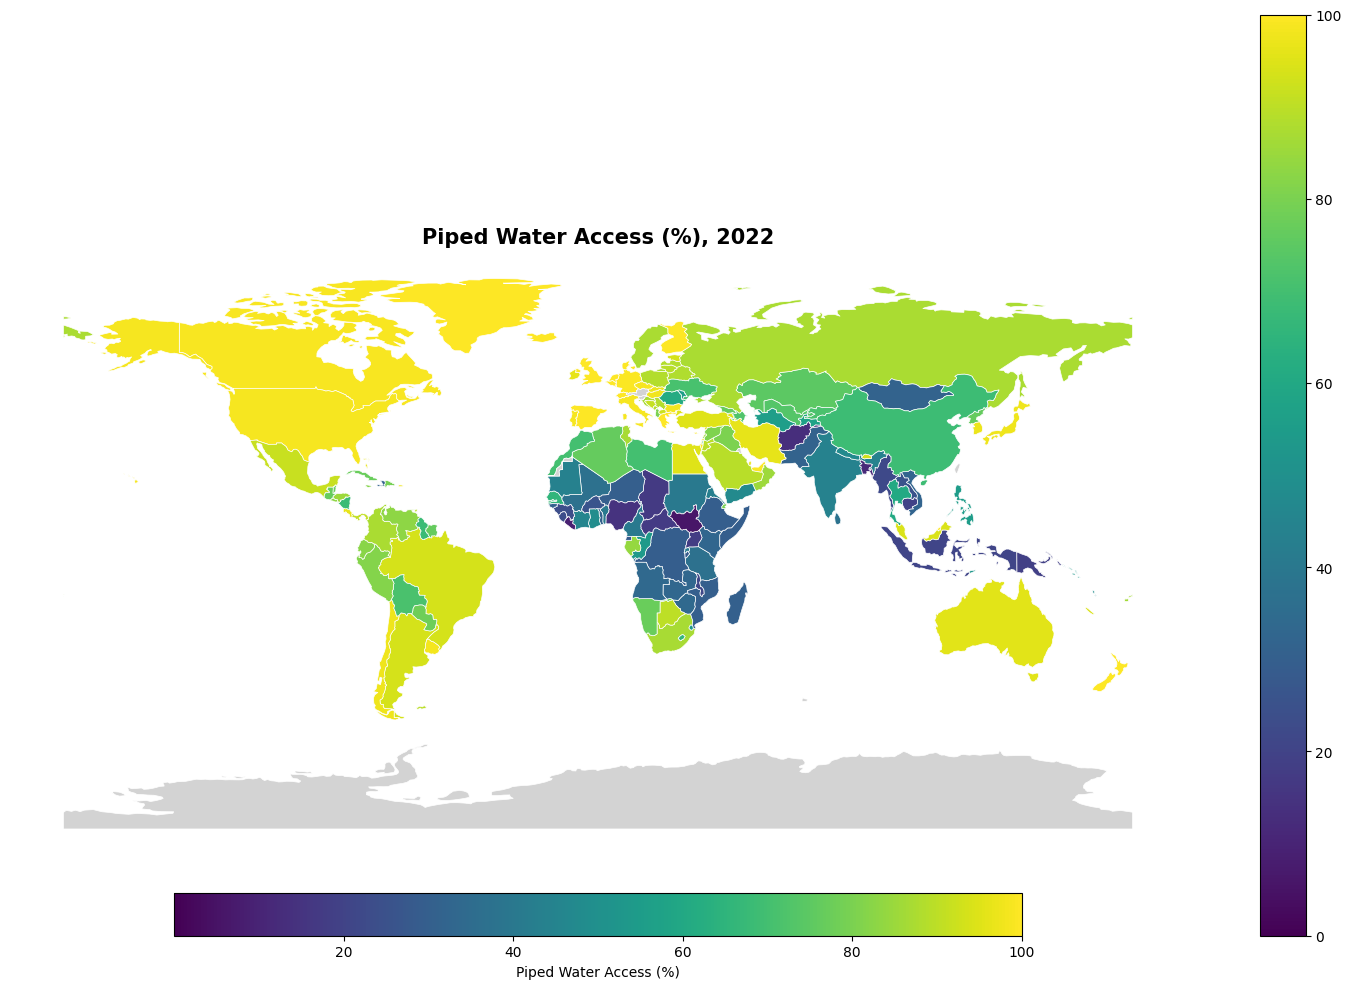

In [12]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot choropleth
piped_map_data.plot(
    column="mean_piped_access",
    cmap="viridis",
    linewidth=0.5,
    edgecolor="white",
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey"},
    vmin=0,
    vmax=100
)

# Customize legend
sm = plt.cm.ScalarMappable(
    cmap="viridis",
    norm=plt.Normalize(vmin=0, vmax=100)
)
sm._A = []
cbar = fig.colorbar(
    sm,
    ax=ax,
    orientation="horizontal",
    fraction=0.046,
    pad=0.04,
    ticks=[20, 40, 60, 80, 100]
)
cbar.set_label("Piped Water Access (%)")

# Final styling
ax.set_title("Piped Water Access (%), 2022", fontdict={'fontsize': 15, 'fontweight': 'bold'})
ax.set_axis_off()
plt.tight_layout()
plt.show()

***Global Piped Water Access Map***

**This map reveals stark contrasts in infrastructure: while countries in Europe and North America enjoy near-universal piped water access, large parts of Africa and Asia still lag far behind. Some countries have less than 20% access.**

In [13]:
import polars as pl
import pandas as pd
from plotnine import *

In [14]:
# Prepare scatter data
scatter_data = (
    merged_data
    .filter(
        (pl.col("indicator").is_in([
            "Proportion of population using piped drinking water sources",
            "Prevalence of overweight among children aged 10-19 years, BMI > +1 standard deviations above the median (Crude estimate)"
        ])) &
        (pl.col("sex") == "Total")
    )
    .select([
        "alpha_3_code",
        "time_period",
        "indicator",
        "obs_value",
        "population,_total",
        "life_expectancy_at_birth,_total_(years)"
    ])
    .pivot(
        values="obs_value",
        index=[
            "alpha_3_code",
            "time_period",
            "population,_total",
            "life_expectancy_at_birth,_total_(years)"
        ],
        on="indicator"
    )
    .rename({
        "Proportion of population using piped drinking water sources": "piped_access",
        "Prevalence of overweight among children aged 10-19 years, BMI > +1 standard deviations above the median (Crude estimate)": "overweight",
        "population,_total": "population",
        "life_expectancy_at_birth,_total_(years)": "life_expectancy"
    })
    .drop_nulls(["piped_access", "overweight", "population", "life_expectancy"])
    .to_pandas()
    .astype({
        "piped_access": "float",
        "overweight": "float",
        "population": "float",
        "life_expectancy": "float"
    })
)

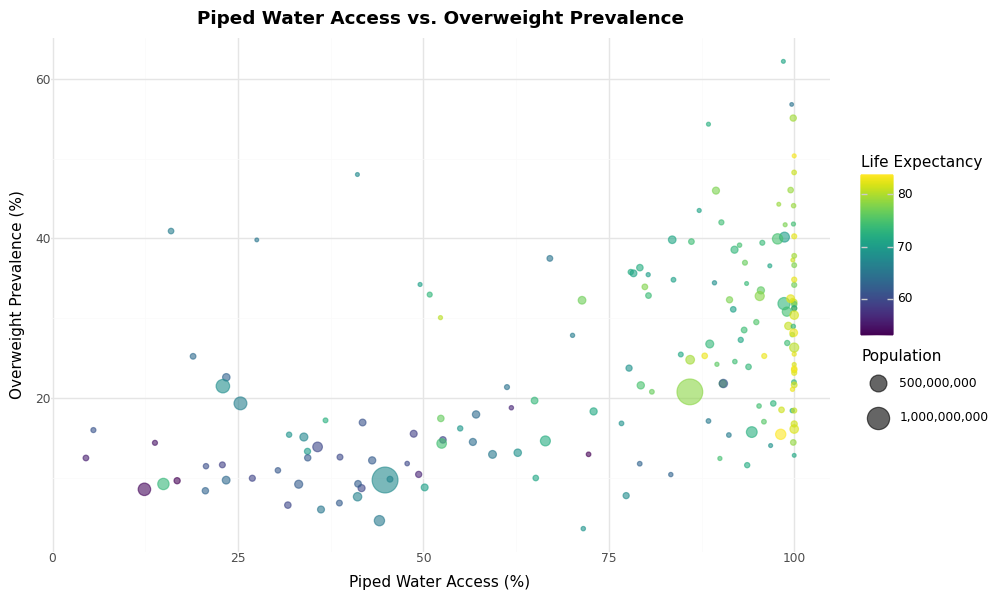

In [15]:
# Round for neater axis and tooltip labels
scatter_data["piped_access"] = scatter_data["piped_access"].round(2)
scatter_data["overweight"] = scatter_data["overweight"].round(2)

# Create plot
plot = (
    ggplot(scatter_data, aes(x='piped_access', y='overweight')) +
    geom_point(aes(size='population', color='life_expectancy'), alpha=0.6) +
    scale_color_continuous(name="Life Expectancy") +
    scale_size_continuous(name="Population", range=(1, 10), labels=lambda l: [f"{int(x):,}" for x in l]) +
    labs(
        title="Piped Water Access vs. Overweight Prevalence",
        x="Piped Water Access (%)",
        y="Overweight Prevalence (%)"
    ) +
    theme_minimal() +
    theme(
        figure_size=(10, 6),
        legend_position='right',
        axis_text_x=element_text(rotation=0),
        axis_text_y=element_text(rotation=0),
        plot_title=element_text(weight='bold')
    )
)

# Show the plot
plot.draw()

***Water Access vs. Overweight Prevalence***

**There is no clear direct correlation between piped water access and overweight prevalence. Some countries with high water access have low obesity rates, while others face an obesity epidemic. This hints that health outcomes are shaped by multiple overlapping factors beyond infrastructure alone.**

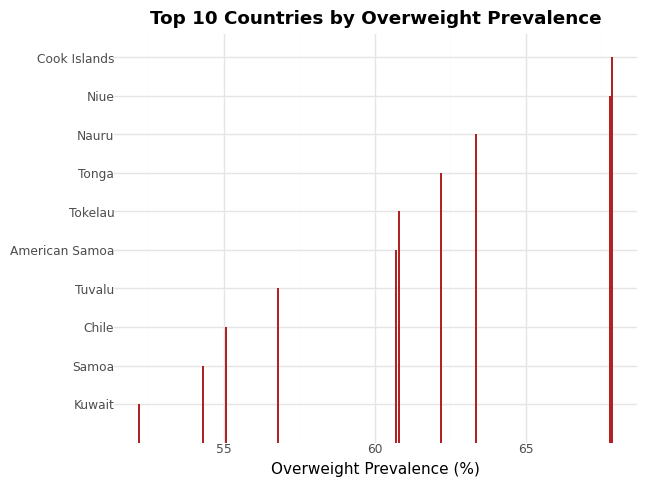

In [16]:
# Extract and prepare top 10 overweight countries
top10_overweight = (
    merged_data
    .filter(
        (pl.col("indicator") == "Prevalence of overweight among children aged 10-19 years, BMI > +1 standard deviations above the median (Crude estimate)") &
        (pl.col("sex") == "Total")
    )
    .group_by("country")
    .agg(pl.col("obs_value").cast(pl.Float64).mean().alias("avg_overweight"))
    .sort("avg_overweight", descending=True)
    .limit(10)
    .to_pandas()
)

# Reorder 'country' factor by overweight value for correct bar order
top10_overweight["country"] = pd.Categorical(
    top10_overweight["country"],
    categories=top10_overweight.sort_values("avg_overweight")["country"],
    ordered=True
)

# Create bar chart using plotnine
bar_plot = (
    ggplot(top10_overweight, aes(x="avg_overweight", y="country")) +
    geom_col(fill="firebrick") +
    labs(
        title="Top 10 Countries by Overweight Prevalence",
        x="Overweight Prevalence (%)",
        y="Country"
    ) +
    theme_minimal() +
    theme(
        plot_title=element_text(face="bold"),
        axis_title_y=element_blank()
    )
)

# Show the plot
bar_plot.draw()

***Top 10 Countries by Overweight Prevalence***

Island nations like **Tonga**, **Tuvalu**, and **Samoa** top the list—despite differing in infrastructure and income level. This points to **cultural, dietary, and lifestyle patterns** contributing to the crisis.

In [17]:
# Prepare overweight prevalence data from Polars
overweight_map_data = (
    merged_data
    .filter(
        (pl.col("indicator") == "Prevalence of overweight among children aged 10-19 years, BMI > +1 standard deviations above the median (Crude estimate)") &
        (pl.col("sex") == "Total")
    )
    .with_columns(
        pl.col("obs_value").cast(pl.Float64)
    )
    .group_by("alpha_3_code")
    .agg(
        pl.col("obs_value").mean().alias("overweight")
    )
    .to_pandas()
)

# Identify join column in GeoDataFrame
join_column = None
for col in ['ISO_A3', 'ADM0_A3', 'iso_a3', 'iso3']:
    if col in world.columns:
        join_column = col
        break
if join_column is None:
    raise ValueError("Could not find ISO3 country code column in world data")

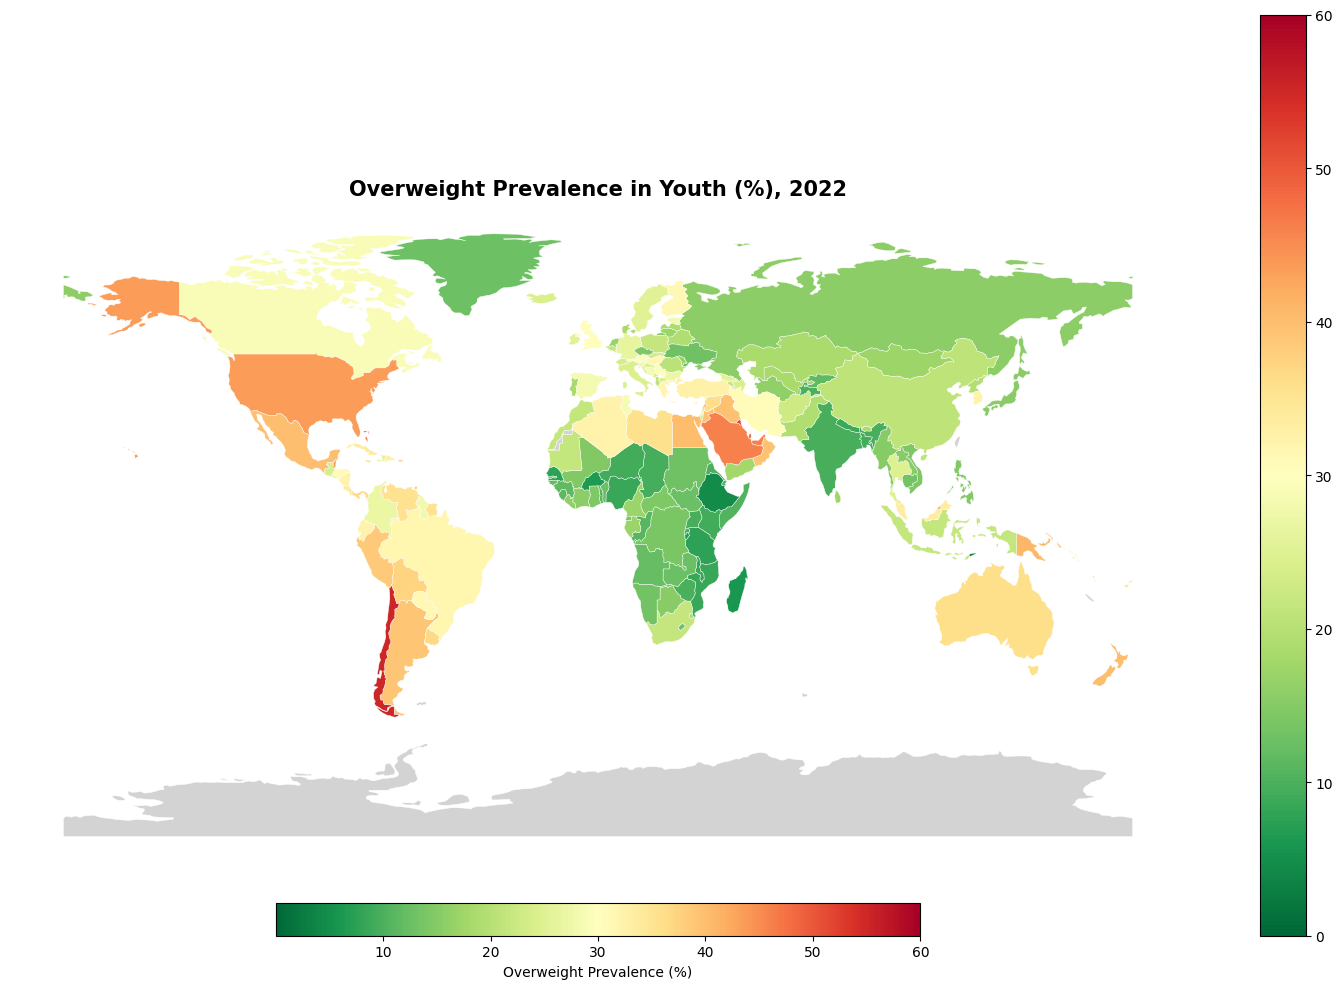

In [18]:
# Merge spatial and overweight data
map_with_overweight = world.merge(
    overweight_map_data,
    left_on=join_column,
    right_on="alpha_3_code",
    how="left"
)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Choropleth
map_with_overweight.plot(
    column="overweight",
    cmap="RdYlGn_r",  # Reverse so green = low, red = high
    linewidth=0.3,
    edgecolor="white",
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgrey"},
    vmin=0,
    vmax=60  
)

# Customize colorbar manually for midpoint and label
sm = plt.cm.ScalarMappable(
    cmap="RdYlGn_r",
    norm=plt.Normalize(vmin=0, vmax=60)
)
sm._A = []
cbar = fig.colorbar(
    sm,
    ax=ax,
    orientation="horizontal",
    fraction=0.035,
    pad=0.04,
    ticks=[10, 20, 30, 40, 50, 60]
)
cbar.set_label("Overweight Prevalence (%)")

# Title and styling
ax.set_title("Overweight Prevalence in Youth (%), 2022", fontdict={'fontsize': 15, 'fontweight': 'bold'})
ax.set_axis_off()
plt.tight_layout()
plt.show()

***Overweight Prevalence in Youth (%), 2022***

Surprisingly, regions with better water infrastructure often show **higher overweight prevalence** among youth indicating that economic growth brings new health challenges, such as sedentary lifestyles and processed diets.

In [19]:
import polars as pl
import pandas as pd
from plotnine import *
import numpy as np
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter

# Prepare data
gdp_scatter = (
    merged_data
    .filter(
        (pl.col("indicator").is_in([
            "Proportion of population using piped drinking water sources",
            "Prevalence of overweight among children aged 10-19 years, BMI > +1 standard deviations above the median (Crude estimate)"
        ])) & 
        (pl.col("sex") == "Total")
    )
    .select([
        "alpha_3_code",
        "time_period",
        "indicator",
        "obs_value",
        "gdp_per_capita_(constant_2015_us$)",
        "population,_total"
    ])
    .pivot(
        values="obs_value",
        index=["alpha_3_code", "time_period", "gdp_per_capita_(constant_2015_us$)", "population,_total"],
        on="indicator"
    )
    .rename({
        "Proportion of population using piped drinking water sources": "piped_access",
        "Prevalence of overweight among children aged 10-19 years, BMI > +1 standard deviations above the median (Crude estimate)": "overweight",
        "gdp_per_capita_(constant_2015_us$)": "gdp_per_capita",
        "population,_total": "population"
    })
    .drop_nulls(["overweight", "gdp_per_capita", "population", "piped_access"])
    .to_pandas()
    .astype({
        "overweight": "float",
        "gdp_per_capita": "float",
        "population": "float",
        "piped_access": "float"
    })
)

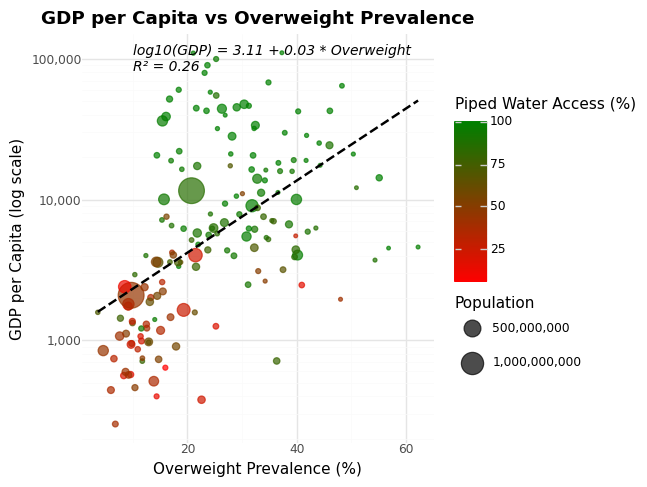

In [20]:
import warnings
warnings.filterwarnings("ignore")

# Fit regression model (log10 GDP ~ overweight)
X = gdp_scatter["overweight"]
X = sm.add_constant(X)
y = np.log10(gdp_scatter["gdp_per_capita"])
model = sm.OLS(y, X).fit()

intercept = round(model.params[0], 2)
slope = round(model.params[1], 2)
r2 = round(model.rsquared, 2)

# Add log10 GDP column to data
gdp_scatter["log10_gdp"] = y

# Create scatter plot
gdp_plot = (
    ggplot(gdp_scatter, aes(x='overweight', y='gdp_per_capita')) +
    geom_point(aes(size='population', color='piped_access'), alpha=0.7) +
    geom_smooth(method='lm', se=False, color='black', linetype='dashed') +
    annotate(
        "text", x=10, y=100000,
        label=f"log10(GDP) = {intercept} + {slope} * Overweight\nR² = {r2}",
        ha='left', size=10, fontstyle='italic'
    ) +
    scale_y_log10(labels=lambda l: [f"{int(x):,}" for x in l]) +
    scale_color_gradient(low='red', high='green', name="Piped Water Access (%)") +
    scale_size_continuous(name="Population", range=(1, 10), labels=lambda l: [f"{int(x):,}" for x in l]) +
    labs(
        title="GDP per Capita vs Overweight Prevalence",
        x="Overweight Prevalence (%)",
        y="GDP per Capita (log scale)"
    ) +
    theme_minimal() +
    theme(
        plot_title=element_text(face='bold'),
        legend_position='right'
    )
)

# Display plot
gdp_plot.draw()

***GDP per Capita vs Overweight Prevalence***

A clear upward trend emerges: as GDP per capita rises, overweight prevalence tends to increase. Wealthier nations face a growing challenge in managing **nutrition-related health risks**, especially among children and teens.

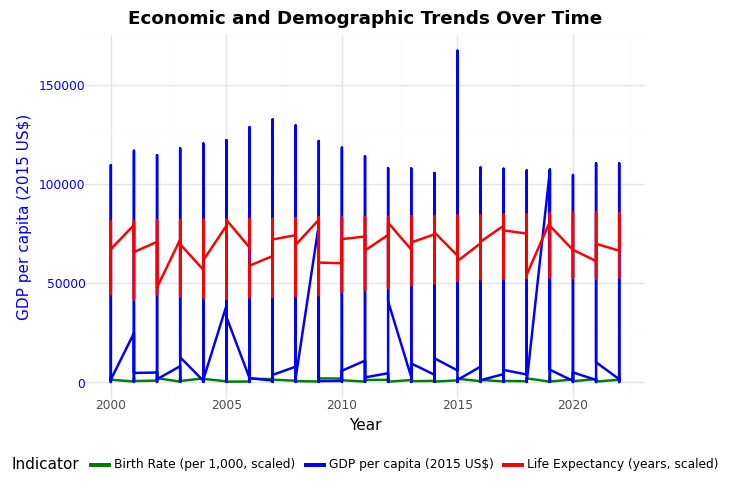

In [21]:
# Extract and clean the data from merged_data
timeseries_data = (
    merged_data
    .select([
        "time_period",
        "gdp_per_capita_(constant_2015_us$)",
        "life_expectancy_at_birth,_total_(years)",
        "birth_rate,_crude_(per_1,000_people)"
    ])
    .drop_nulls()
    .unique()
    .to_pandas()
    .astype({
        "time_period": "int",
        "gdp_per_capita_(constant_2015_us$)": "float",
        "life_expectancy_at_birth,_total_(years)": "float",
        "birth_rate,_crude_(per_1,000_people)": "float"
    })
)

# Rename columns for ease of use
timeseries_data = timeseries_data.rename(columns={
    "gdp_per_capita_(constant_2015_us$)": "gdp_per_capita",
    "life_expectancy_at_birth,_total_(years)": "life_expectancy",
    "birth_rate,_crude_(per_1,000_people)": "birth_rate"
})

# Scale life expectancy and birth rate for single-axis plot
timeseries_data["life_expectancy_scaled"] = timeseries_data["life_expectancy"] * 1000
timeseries_data["birth_rate_scaled"] = timeseries_data["birth_rate"] * 50

# Melt the dataframe for ggplot-style long format
long_df = pd.melt(
    timeseries_data,
    id_vars=["time_period"],
    value_vars=["gdp_per_capita", "life_expectancy_scaled", "birth_rate_scaled"],
    var_name="indicator",
    value_name="value"
)

# Map proper indicator labels
indicator_labels = {
    "gdp_per_capita": "GDP per capita (2015 US$)",
    "life_expectancy_scaled": "Life Expectancy (years, scaled)",
    "birth_rate_scaled": "Birth Rate (per 1,000, scaled)"
}
long_df["indicator"] = long_df["indicator"].map(indicator_labels)

# Create plot
ts_plot = (
    ggplot(long_df, aes(x='time_period', y='value', color='indicator')) +
    geom_line(size=1) +
    scale_color_manual(
        name="Indicator",
        values={
            "GDP per capita (2015 US$)": "blue",
            "Life Expectancy (years, scaled)": "red",
            "Birth Rate (per 1,000, scaled)": "green"
        }
    ) +
    labs(
        title="Economic and Demographic Trends Over Time",
        x="Year",
        y="GDP per capita (2015 US$)"
    ) +
    theme_minimal() +
    theme(
        legend_position='bottom',
        axis_title_y=element_text(color="blue"),
        axis_text_y=element_text(color="blue"),
        plot_title=element_text(weight='bold')
    )
)

# Show the plot
ts_plot.draw()

***Economic and Health Trends Over Time***

As GDP rises, life expectancy improves and birth rates decline — highlighting how economic growth shapes public health and demographics.

**Implications**

The analysis highlights several critical insights into global public health, infrastructure, and economic development:

1. **Infrastructure Disparities**: Access to piped drinking water remains a significant challenge in many regions, particularly in parts of Africa and Asia. This disparity underscores the urgent need for investments in basic infrastructure to improve public health outcomes.

2. **Health Challenges in Wealthier Nations**: While economic growth often leads to improved infrastructure and life expectancy, it also introduces new health challenges, such as rising overweight prevalence among children and youth. This trend is particularly evident in wealthier nations, where sedentary lifestyles and processed diets are becoming more common.

3. **Economic and Health Correlations**: The positive correlation between GDP per capita and life expectancy demonstrates the importance of economic development in improving health outcomes. However, the simultaneous rise in overweight prevalence with GDP suggests that economic growth must be accompanied by public health policies to address emerging health risks.

4. **Regional Variations**: The stark contrasts between regions in terms of water access, overweight prevalence, and other indicators highlight the need for targeted, region-specific interventions to address unique challenges.

**Call to Action**

To address these challenges and foster sustainable development, the following actions are recommended:

1. **Invest in Infrastructure**: Governments and international organizations must prioritize investments in clean water infrastructure, particularly in underserved regions, to ensure equitable access to basic necessities.

2. **Promote Healthy Lifestyles**: Public health campaigns should focus on promoting balanced diets and active lifestyles, especially in economically developed regions where overweight prevalence is rising.

3. **Strengthen Data-Driven Policies**: Policymakers should leverage data and insights from analyses like this to design targeted interventions that address specific regional and demographic needs.

4. **Foster Global Collaboration**: Achieving sustainable development goals requires collaboration between governments, NGOs, and the private sector to pool resources and expertise for maximum impact.

5. **Monitor and Evaluate Progress**: Regular monitoring and evaluation of key indicators, such as water access, overweight prevalence, and life expectancy, are essential to track progress and refine strategies over time.